In [133]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import seaborn as sns
import matplotlib.pyplot as plt

In [134]:

file_path = '../../data/processed/feature_selected_data.parquet'
df = pd.read_parquet(file_path, engine= 'pyarrow')

In [135]:
# df.descrizione_attivita.value_counts()

In [136]:
# questo è un TODO definito nel file feature_selection.py ma ancora non fatto
df.drop(columns=['codice_struttura_erogazione'], inplace=True)
df['durata_erogazione_sec'] =  df.durata_erogazione_sec.astype(int)

In [137]:
df.columns

Index(['id_prenotazione', 'id_paziente', 'data_nascita', 'sesso',
       'regione_residenza', 'tipologia_servizio', 'descrizione_attivita',
       'data_contatto', 'tipologia_struttura_erogazione',
       'id_professionista_sanitario', 'tipologia_professionista_sanitario',
       'data_erogazione', 'durata_erogazione_sec', 'fascia_eta', 'anno',
       'quadrimestre'],
      dtype='object')

In [138]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 460509 entries, 0 to 484290
Data columns (total 16 columns):
 #   Column                              Non-Null Count   Dtype              
---  ------                              --------------   -----              
 0   id_prenotazione                     460509 non-null  object             
 1   id_paziente                         460509 non-null  object             
 2   data_nascita                        460509 non-null  datetime64[ns, UTC]
 3   sesso                               460509 non-null  object             
 4   regione_residenza                   460509 non-null  object             
 5   tipologia_servizio                  460509 non-null  object             
 6   descrizione_attivita                460509 non-null  object             
 7   data_contatto                       460509 non-null  object             
 8   tipologia_struttura_erogazione      460509 non-null  object             
 9   id_professionista_sanitario    

In [139]:
cols_grouped = ['anno', 'quadrimestre', 'regione_residenza', 'tipologia_struttura_erogazione', 'fascia_eta']

In [140]:
grouped = df.groupby(cols_grouped).size().reset_index(name='num_servizi')

In [141]:
grouped.sort_values(by=['num_servizi'], ascending=True)

,anno,quadrimestre,regione_residenza,tipologia_struttura_erogazione,fascia_eta,num_servizi
3736,2021,1,Valle d'aosta,IRCCS pubblico,36-47,1
3744,2021,1,Valle d'aosta,Policlinico universitario privato,12-23,1
120,2019,1,Lazio,IRCCS pubblico,70+,1
6522,2022,4,Molise,Azienda Ospedaliera Universitaria,12-23,1
6523,2022,4,Molise,Azienda Ospedaliera Universitaria,24-35,1
...,...,...,...,...,...,...
3330,2020,4,Veneto,Ospedale a gestione diretta,0-11,939
3509,2021,1,Lombardia,Ospedale a gestione diretta,12-23,1110
3079,2020,4,Lombardia,Ospedale a gestione diretta,12-23,1162
3508,2021,1,Lombardia,Ospedale a gestione diretta,0-11,1275


In [142]:
df_cols_no_anno = cols_grouped.copy()
df_cols_no_anno.remove('anno')

In [143]:
# Calcolo dell'incremento per ogni quadrimestre
grouped['incremento'] = grouped.groupby(df_cols_no_anno)['num_servizi'].diff()


In [144]:
grouped.sort_values(by=['incremento'], ascending=False)

,anno,quadrimestre,regione_residenza,tipologia_struttura_erogazione,fascia_eta,num_servizi,incremento
3078,2020,4,Lombardia,Ospedale a gestione diretta,0-11,1386,1088.0
3508,2021,1,Lombardia,Ospedale a gestione diretta,0-11,1275,831.0
3079,2020,4,Lombardia,Ospedale a gestione diretta,12-23,1162,822.0
3330,2020,4,Veneto,Ospedale a gestione diretta,0-11,939,762.0
3509,2021,1,Lombardia,Ospedale a gestione diretta,12-23,1110,721.0
...,...,...,...,...,...,...,...
6708,2022,4,Umbria,Fondazione IRCCS,48-59,1,NaN
6710,2022,4,Umbria,IRCCS pubblico,70+,1,NaN
6719,2022,4,Valle d'aosta,Fondazione IRCCS,48-59,1,NaN
6720,2022,4,Valle d'aosta,IRCCS privato,36-47,1,NaN


In [145]:
# mask = (grouped['regione_residenza'] == 'Sicilia') & (grouped['quadrimestre'] == 4)
# grouped[mask].sort_values(by=['anno'])

In [146]:
# DA NON FARE - Elimino i campioni con incremento nullo, sono quelli del 2019 (primo anno storicizzato)
# grouped = grouped.dropna(subset=['incremento'])

In [147]:

# Calcolo dell'incremento percentuale
grouped['incremento_percentuale'] = grouped['incremento'] / grouped.groupby(df_cols_no_anno)['num_servizi'].shift(1) * 100   # shift(1) per avere il valore precedente

# Calcolo dell'incremento percentuale medio per ogni coppia di quadrimestre e regione_erogazione
incremento_percentuale_medio = grouped.groupby(df_cols_no_anno)['incremento_percentuale'].mean().reset_index()

# Visualizza il risultato
app = incremento_percentuale_medio.sort_values(by=['incremento_percentuale'], ascending=False)
app

,quadrimestre,regione_residenza,tipologia_struttura_erogazione,fascia_eta,incremento_percentuale
491,2,Basilicata,Ospedale a gestione diretta,70+,804.666667
804,2,Sardegna,Azienda Ospedaliera Universitaria,12-23,625.384615
1743,4,Puglia,IRCCS privato,0-11,621.269841
251,1,Piemonte,IRCCS privato,0-11,603.571429
1820,4,Toscana,Ente di Ricerca,0-11,489.215686
...,...,...,...,...,...
1871,4,Valle d'aosta,Azienda Ospedaliera Universitaria,60-69,NaN
1872,4,Valle d'aosta,Fondazione IRCCS,48-59,NaN
1873,4,Valle d'aosta,IRCCS privato,36-47,NaN
1874,4,Valle d'aosta,IRCCS privato,60-69,NaN


In [148]:
# Visualizzo l'incremento percentuale anno in anno
# mask = (grouped['regione_residenza'] == 'Sicilia') & (grouped['quadrimestre'] == 4)
# grouped[mask]

In [149]:
# Visualizzo, in un nuovo dataframe, l'incremento percentuale medio per ogni coppia di quadrimestre e regione_residenza
mask = (incremento_percentuale_medio['regione_residenza'] == 'Sicilia') & (incremento_percentuale_medio['quadrimestre'] == 4)
incremento_percentuale_medio[mask]

,quadrimestre,regione_residenza,tipologia_struttura_erogazione,fascia_eta,incremento_percentuale
1778,4,Sicilia,Azienda Ospedaliera,0-11,112.755131
1779,4,Sicilia,Azienda Ospedaliera,12-23,96.303375
1780,4,Sicilia,Azienda Ospedaliera,24-35,1.445469
1781,4,Sicilia,Azienda Ospedaliera,36-47,1.814966
1782,4,Sicilia,Azienda Ospedaliera,48-59,10.161461
1783,4,Sicilia,Azienda Ospedaliera,60-69,23.775291
1784,4,Sicilia,Azienda Ospedaliera,70+,-2.523249
1785,4,Sicilia,Azienda Ospedaliera Universitaria,0-11,185.093468
1786,4,Sicilia,Azienda Ospedaliera Universitaria,12-23,23.707610
1787,4,Sicilia,Azienda Ospedaliera Universitaria,24-35,0.238840


Per studiare i dati e determinare le soglie appropriate per l'assegnazione delle etichette, puoi seguire alcuni passaggi che ti aiuteranno a comprendere meglio la distribuzione degli incrementi percentuali. Ecco una guida pratica su come fare:

1. Esplora la Distribuzione degli Incrementi Percentuali
Distribuzione: 
- Usa un istogramma o un grafico a densità per visualizzare la distribuzione degli incrementi percentuali.
- Statistica Descrittiva: Calcola metriche come la media, la mediana, i quartili, e la deviazione standard.

2. Identifica Valori Estremi (Outliers)
- Gli outlier possono influenzare significativamente le soglie. Identificare e, se necessario, trattare questi valori può essere utile.
- Puoi usare boxplot o interquartile range (IQR) per individuare gli outlier.

3. Segmentazione basata su Quartili
- I quartili (Q1, Q2, Q3) dividono i dati in quattro parti uguali. Usarli per definire le soglie può aiutarti a segmentare in modo equilibrato.

4. Visualizzazione dei Dati
- Scatter plot: Un grafico scatter può aiutare a vedere la relazione tra l'anno e l'incremento percentuale.
- Boxplot: Un boxplot mostra la distribuzione e può evidenziare outlier e valori medi.

In [150]:
# NB: forse i seguenti grafici sono inutili per il momento, ma li lascio per completezza

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns


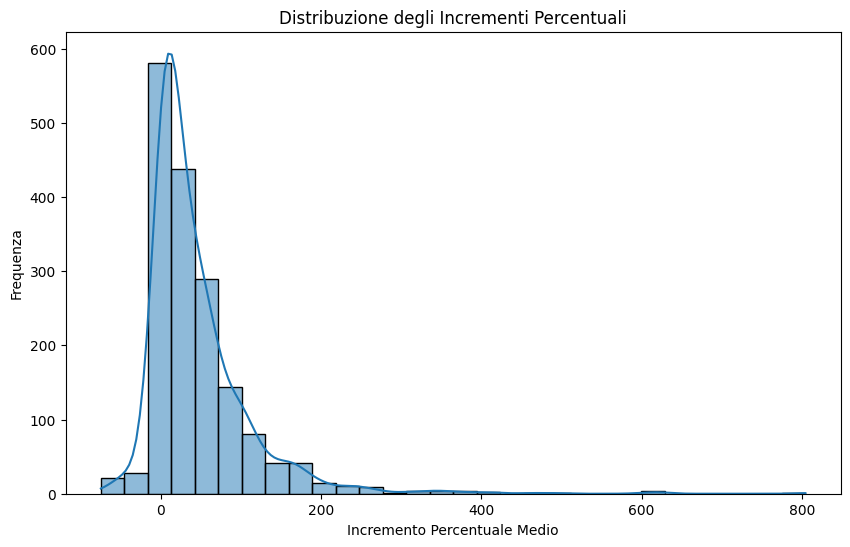

In [152]:
# Calcola la distribuzione degli incrementi percentuali
plt.figure(figsize=(10, 6))
sns.histplot(incremento_percentuale_medio['incremento_percentuale'], bins=30, kde=True)
plt.title('Distribuzione degli Incrementi Percentuali')
plt.xlabel('Incremento Percentuale Medio')
plt.ylabel('Frequenza')
plt.show()

In [153]:
# Statistiche descrittive
descr = incremento_percentuale_medio['incremento_percentuale'].describe()
print(descr)

count    1715.000000
mean       45.051739
std        66.839245
min       -75.000000
25%         6.313614
50%        25.000000
75%        62.660079
max       804.666667
Name: incremento_percentuale, dtype: float64


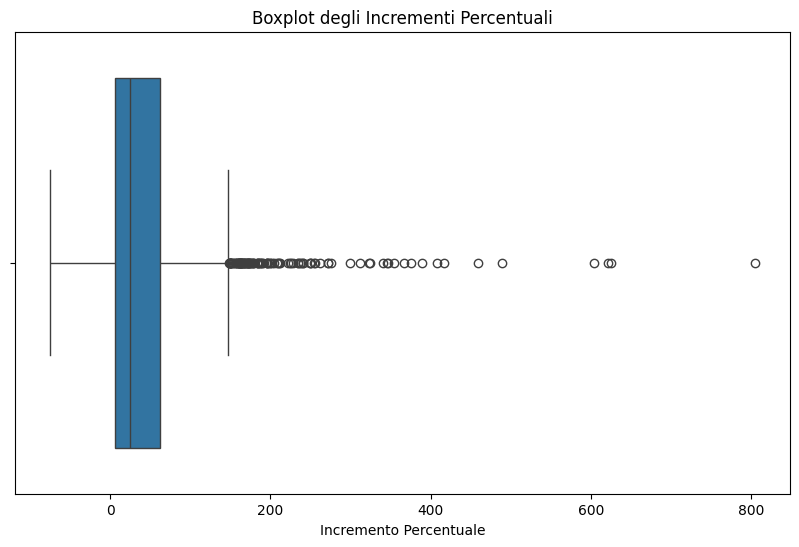

In [154]:
# Boxplot per identificare outliers
plt.figure(figsize=(10, 6))
sns.boxplot(x=incremento_percentuale_medio['incremento_percentuale'])
plt.title('Boxplot degli Incrementi Percentuali')
plt.xlabel('Incremento Percentuale')
plt.show()

In [155]:
# TODO: dobbiamo identificare anche il decremento?
    # IGNAZIO: si, ci possono essere degli incrementi percentuali medi negativi. Già verificato :(

def classify_increment(value):
    constat_increment = 5 
    low_increment = 15
    medium_increment = 40

    # TODO: fixare, bisogna mettere >= 0 nel primo if
    if value <= constat_increment and value >= 0:
        return 'constant_increment'
    elif value <= low_increment:
        return 'low_increment'
    elif value <= medium_increment:
        return 'medium_increment'
    elif value > medium_increment:
        return 'high_increment'
    else:
        return 'decrement'

In [156]:
incremento_percentuale_medio['incremento_teleassistenze'] = incremento_percentuale_medio['incremento_percentuale'].apply(classify_increment)

In [157]:
incremento_percentuale_medio.sort_values(by=['incremento_percentuale'], ascending=False)

,quadrimestre,regione_residenza,tipologia_struttura_erogazione,fascia_eta,incremento_percentuale,incremento_teleassistenze
491,2,Basilicata,Ospedale a gestione diretta,70+,804.666667,high_increment
804,2,Sardegna,Azienda Ospedaliera Universitaria,12-23,625.384615,high_increment
1743,4,Puglia,IRCCS privato,0-11,621.269841,high_increment
251,1,Piemonte,IRCCS privato,0-11,603.571429,high_increment
1820,4,Toscana,Ente di Ricerca,0-11,489.215686,high_increment
...,...,...,...,...,...,...
1871,4,Valle d'aosta,Azienda Ospedaliera Universitaria,60-69,NaN,decrement
1872,4,Valle d'aosta,Fondazione IRCCS,48-59,NaN,decrement
1873,4,Valle d'aosta,IRCCS privato,36-47,NaN,decrement
1874,4,Valle d'aosta,IRCCS privato,60-69,NaN,decrement


In [158]:
mask = (incremento_percentuale_medio['incremento_teleassistenze'] == 'high_increment')
incremento_percentuale_medio[mask]


,quadrimestre,regione_residenza,tipologia_struttura_erogazione,fascia_eta,incremento_percentuale,incremento_teleassistenze
0,1,Abruzzo,Ospedale a gestione diretta,0-11,139.410774,high_increment
1,1,Abruzzo,Ospedale a gestione diretta,12-23,117.323481,high_increment
2,1,Abruzzo,Ospedale a gestione diretta,24-35,87.535476,high_increment
3,1,Abruzzo,Ospedale a gestione diretta,36-47,53.217938,high_increment
5,1,Abruzzo,Ospedale a gestione diretta,60-69,58.864268,high_increment
...,...,...,...,...,...,...
1884,4,Veneto,Azienda Ospedaliera,12-23,61.891253,high_increment
1890,4,Veneto,Azienda Ospedaliera Universitaria,0-11,69.378307,high_increment
1897,4,Veneto,IRCCS pubblico,48-59,100.000000,high_increment
1900,4,Veneto,Ospedale a gestione diretta,0-11,115.398732,high_increment


In [159]:
# df['incremento_teleassistenze'] = df.apply(lambda x: incremento_percentuale_medio.loc[(incremento_percentuale_medio['regione_erogazione'] == x['regione_erogazione']) & (incremento_percentuale_medio['quadrimestre'] == x['quadrimestre'])]['incremento_teleassistenze'].values[0], axis=1)


# Qui vado a mappare il valore di incremento_teleassistenze nel dataframe principale (ci mette un po ad eseguirsi)


#df['incremento_teleassistenze'] = df.apply(lambda x: incremento_percentuale_medio.loc[
#    (incremento_percentuale_medio[df_cols_no_anno] == x[df_cols_no_anno].values).all(axis=1)
#]['incremento_teleassistenze'].values[0], axis=1)


In [160]:
df = df.merge(incremento_percentuale_medio[df_cols_no_anno + ['incremento_teleassistenze']], 
              on=df_cols_no_anno, 
              how='left')

In [161]:
df.incremento_teleassistenze.value_counts()

incremento_teleassistenze
high_increment        164778
low_increment         159351
medium_increment       89232
constant_increment     46903
decrement                245
Name: count, dtype: int64

In [162]:
df.to_parquet('../../data/processed/ds_labeled.parquet')


## CONTINUA NEL NOTEBOOK "importanza_feature_uff (non necessario per ora)

In [163]:
# mask = (df.regione_residenza == 'Lazio') & (df.sesso == 'male') & (df.tipologia_struttura_erogazione == 'Fondazione IRCCS') & (df.quadrimestre == 1)
# df[mask]

In [164]:
# mask = (df.regione_residenza == 'Abruzzo') & (df.sesso == 'female') & (df.tipologia_struttura_erogazione == 'Ospedale a gestione diretta') & (df.quadrimestre == 1)
# up = df[mask]

In [165]:
# up.incremento_teleassistenze.value_counts()